<a href="https://colab.research.google.com/github/koushikgk/python_codes/blob/master/solar_faster_rcnn_city.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 29870, done.
remote: Counting objects: 100% (2412/2412), done.
remote: Compressing objects: 100% (637/637), done.
remote: Total 29870 (delta 1823), reused 2277 (delta 1730), pack-reused 27458
Receiving objects: 100% (29870/29870), 37.80 MiB | 34.94 MiB/s, done.
Resolving deltas: 100% (22438/22438), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
# ! pip install albumentations==0.4.6
# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2

# from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# files_dir = "/content/gdrive/MyDrive/solar_city_files/train_not_ours/"
files_dir = "/content/gdrive/MyDrive/solar_city_files/images_with_solar/"

class SolarImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.png']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'solar', 'roof']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        try:
          boxes = []
          labels = []
          tree = et.parse(annot_file_path)
          root = tree.getroot()
          
          # cv2 image gives size as height x width
          wt = img.shape[1]
          ht = img.shape[0]
          
          # box coordinates for xml files are extracted and corrected for image size given
          for member in root.findall('object'):
              labels.append(self.classes.index(member.find('name').text))
              
              # bounding box
              xmin = int(member.find('bndbox').find('xmin').text)
              xmax = int(member.find('bndbox').find('xmax').text)
              
              ymin = int(member.find('bndbox').find('ymin').text)
              ymax = int(member.find('bndbox').find('ymax').text)
                       
              xmin_corr = (xmin/wt)*self.width
              xmax_corr = (xmax/wt)*self.width
              ymin_corr = (ymin/ht)*self.height
              ymax_corr = (ymax/ht)*self.height
              
              boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
          
          # convert boxes into a torch.Tensor
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          
          # getting the areas of the boxes
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

          # suppose all instances are not crowd
          iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
          
          labels = torch.as_tensor(labels, dtype=torch.int64)

          target = {}
          target["boxes"] = boxes
          target["labels"] = labels
          target["area"] = area
          target["iscrowd"] = iscrowd
          # image_id
          image_id = torch.tensor([idx])
          target["image_id"] = image_id

          if self.transforms:            
            img_res = self.transforms(img_res)             
          #   sample = self.transforms(image = img_res,
          #                            bboxes = target['boxes'],
          #                            labels = labels)
            
          #   img_res = sample['image']
          #   target['boxes'] = torch.Tensor(sample['bboxes'])

          return img_res, target

        except:
          if self.transforms:
            img_res = self.transforms(img_res)
          return img_res

    def __len__(self):
        return len(self.imgs)

# check dataset
dataset = SolarImagesDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[50]
print(img.shape, '\n',target)

length of dataset =  70 

(224, 224, 3) 
 {'boxes': tensor([[9.2750e+01, 1.0220e+02, 1.2810e+02, 1.5330e+02],
        [1.0657e+02, 2.8700e+01, 1.4735e+02, 9.0475e+01],
        [1.6380e+02, 3.5000e-01, 2.2400e+02, 3.5525e+01],
        [1.7500e-01, 3.6225e+01, 1.8200e+01, 7.7875e+01],
        [3.5000e-01, 1.0168e+02, 1.9600e+01, 1.4577e+02],
        [3.5000e-01, 1.6205e+02, 2.1175e+01, 2.1665e+02],
        [9.2225e+01, 1.6765e+02, 1.3055e+02, 2.1612e+02],
        [9.4325e+01, 1.2285e+02, 1.0500e+02, 1.3982e+02],
        [1.1795e+02, 3.6925e+01, 1.3685e+02, 6.8600e+01]]), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 1, 1]), 'area': tensor([1806.3855, 2518.8760, 2117.5352,  750.7413,  848.9248, 1137.0448,
        1857.8048,  181.2082,  598.6578]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]), 'image_id': tensor([50])}


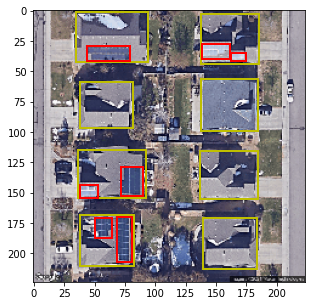

In [ ]:
def plot_img_bbox(img, target=None):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    colors = ['r', 'y']
    try:
      for box, label in zip(target['boxes'], target['labels']):
          x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
          rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = colors[label-1],
                                 facecolor = 'none')

          # Draw the bounding box on top of the image
          a.add_patch(rect)
      plt.show()
    except:
      plt.show()
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[69]
plot_img_bbox(img, target)

In [ ]:
# def fasterrcnn_resnet152_fpn(pretrained=False, progress=True,
#                             num_classes=91, pretrained_backbone=False,
#                              trainable_backbone_layers=3, **kwargs):
#     assert trainable_backbone_layers <= 5 and trainable_backbone_layers >= 0
#     # dont freeze any layers if pretrained model or backbone is not used
#     if not (pretrained or pretrained_backbone):
#         trainable_backbone_layers = 5
#     if pretrained:
#         # no need to download the backbone if pretrained is set
#         pretrained_backbone = False
#     backbone = resnet_fpn_backbone('resnet152', pretrained_backbone)
#     model = FasterRCNN(backbone, num_classes, **kwargs)
#     return model

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # model = fasterrcnn_resnet152_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
# Send train=True fro training transforms and False for val/test transforms
# def get_transform(train):
    
#     if train:
#         return A.Compose([
#                             A.HorizontalFlip(0.5),
#                      # ToTensorV2 converts image to pytorch tensor without div by 255
#                             ToTensorV2(p=1.0) 
#                         ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
#     else:
#         return A.Compose([
#                             ToTensorV2(p=1.0)
#                         ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
dataset1 = SolarImagesDataset(files_dir, 480, 480, transforms=torchtrans.ToTensor())
# dataset = SolarImagesDataset(files_dir, 480, 480, transforms= get_transform(train=True))
# dataset_test = SolarImagesDataset(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset1)*test_split)
dataset = torch.utils.data.Subset(dataset1, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset1, indices[-tsize:])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 3

# get the model using our helper function
try:
  print(to_skip_try_clause)
  model.load_state_dict(torch.load("/content/gdrive/MyDrive/solar_city_files/solar_fine-tuned.pt"))
  print("Loading pre-finetuned model...")
except:
  print("No pre-finetuned model found... loading new pre-trained from torchvision...")
  model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.01,
#                             momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.AdamW(params, lr=0.0002, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=1,
                                               gamma=0.8)

No pre-finetuned model found... loading new pre-trained from torchvision...


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
def train_mnist(config, model, params, data_loader, data_loader_test, device):
    optimizer = torch.optim.AdamW(params, lr=config["lr"], weight_decay=0.0005)
    for i in range(10):
        train(model, optimizer, data_loader)
        acc = evaluate(model, data_loader_test, device=device)
        tune.report(mean_accuracy=acc)

analysis = tune.run(
    train_mnist, config={"lr": tune.grid_search([0.001, 0.01, 0.1])}, model, params, data_loader, data_loader_test, device)

print("Best config: ", analysis.get_best_config(metric="mean_accuracy"))

# Get a dataframe for analyzing trial results.
df = analysis.dataframe()

In [ ]:
# training for 10 epochs
num_epochs = 8

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    # print(acc.coco_eval.values.accumulate())

Epoch: [0]  [0/7]  eta: 0:00:18  lr: 0.000034  loss: 1.4859 (1.4859)  loss_classifier: 0.4949 (0.4949)  loss_box_reg: 0.7814 (0.7814)  loss_objectness: 0.1476 (0.1476)  loss_rpn_box_reg: 0.0621 (0.0621)  time: 2.5989  data: 0.9296  max mem: 6190
Epoch: [0]  [6/7]  eta: 0:00:01  lr: 0.000200  loss: 1.3372 (1.3059)  loss_classifier: 0.4890 (0.4740)  loss_box_reg: 0.6972 (0.7073)  loss_objectness: 0.0928 (0.0893)  loss_rpn_box_reg: 0.0276 (0.0353)  time: 1.6585  data: 0.1526  max mem: 6190
Epoch: [0] Total time: 0:00:11 (1.6705 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:03  model_time: 0.7015 (0.7015)  evaluator_time: 0.2491 (0.2491)  time: 1.5188  data: 0.5615  max mem: 6190
Test:  [1/2]  eta: 0:00:01  model_time: 0.4890 (0.5953)  evaluator_time: 0.0913 (0.1702)  time: 1.0538  data: 0.2824  max mem: 6190
Test: Total time: 0:00:02 (1.0969 s / it)
Averaged stats: model_time: 0.4890 (0.5953)  evaluator_time: 0.0913 (0.1702)
Accumulating evaluation results...
DONE (t=0.

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/solar_city_files/solar_fine-tuned.pt")

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction, final_prediction['boxes']
    
# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

predicted #boxes:  23
real #boxes:  9
EXPECTED OUTPUT


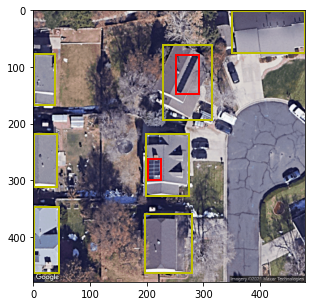

NMS APPLIED MODEL OUTPUT


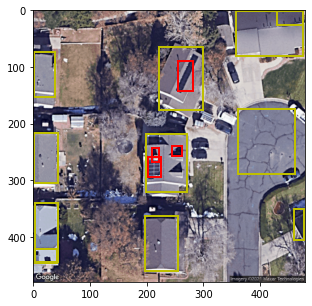

Ratio of area covered by PV to the total image =  0.25626900792121887
predicted #boxes:  50
real #boxes:  15
EXPECTED OUTPUT


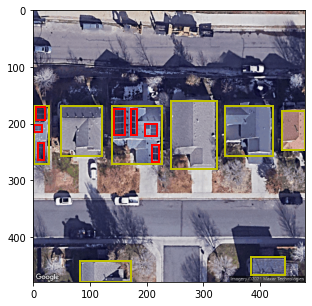

NMS APPLIED MODEL OUTPUT


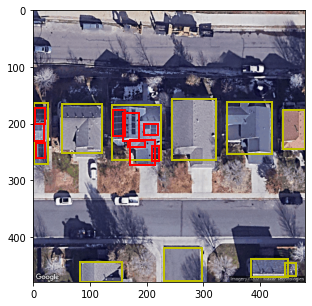

Ratio of area covered by PV to the total image =  0.22484034299850464
predicted #boxes:  12
real #boxes:  7
EXPECTED OUTPUT


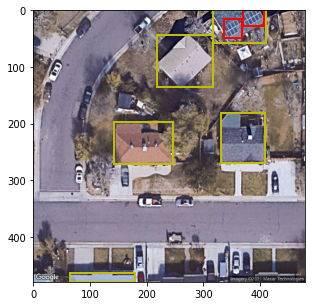

NMS APPLIED MODEL OUTPUT


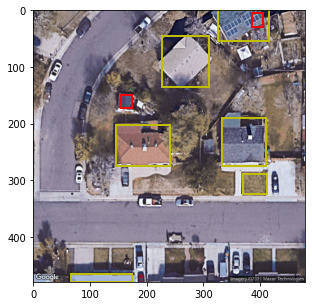

Ratio of area covered by PV to the total image =  0.12929536402225494
predicted #boxes:  39
real #boxes:  12
EXPECTED OUTPUT


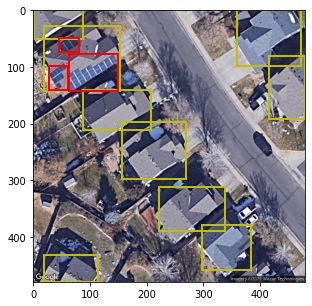

NMS APPLIED MODEL OUTPUT


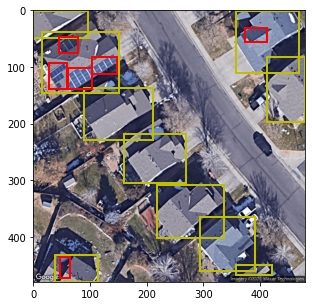

Ratio of area covered by PV to the total image =  0.39765217900276184
predicted #boxes:  26
real #boxes:  8
EXPECTED OUTPUT


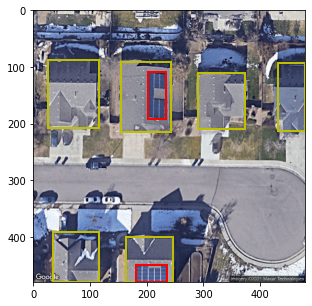

NMS APPLIED MODEL OUTPUT


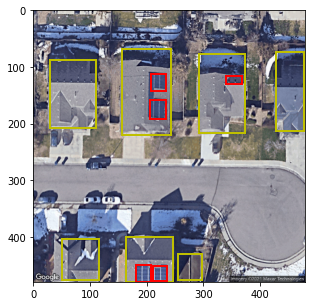

Ratio of area covered by PV to the total image =  0.25281888246536255
predicted #boxes:  21
real #boxes:  8
EXPECTED OUTPUT


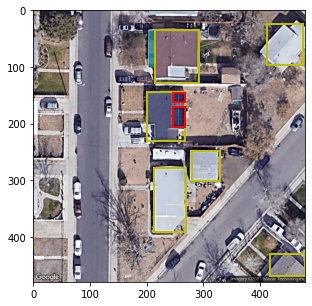

NMS APPLIED MODEL OUTPUT


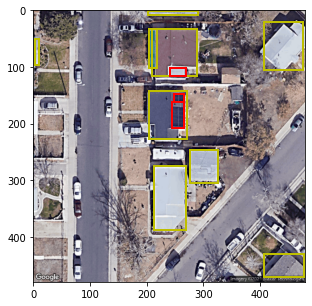

Ratio of area covered by PV to the total image =  0.14675834774971008
predicted #boxes:  29
real #boxes:  12
EXPECTED OUTPUT


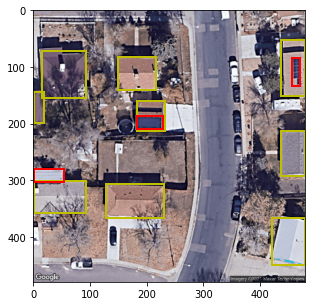

NMS APPLIED MODEL OUTPUT


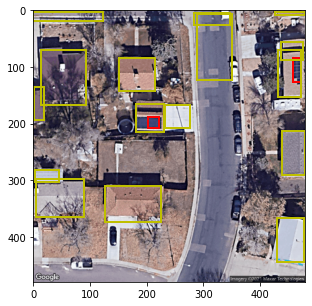

Ratio of area covered by PV to the total image =  0.23195801675319672
predicted #boxes:  18
real #boxes:  8
EXPECTED OUTPUT


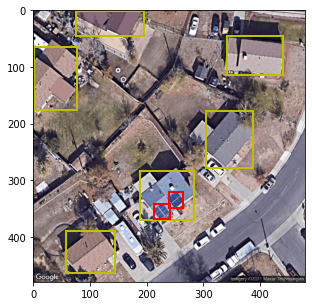

NMS APPLIED MODEL OUTPUT


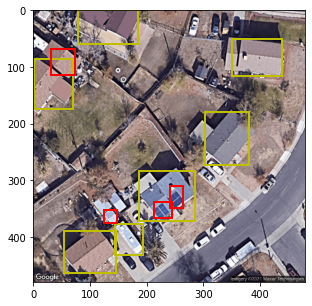

Ratio of area covered by PV to the total image =  0.20832639932632446
predicted #boxes:  33
real #boxes:  11
EXPECTED OUTPUT


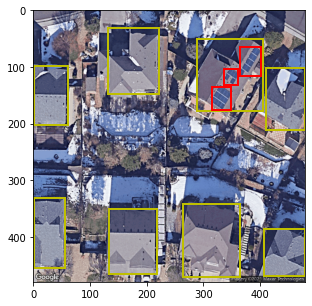

NMS APPLIED MODEL OUTPUT


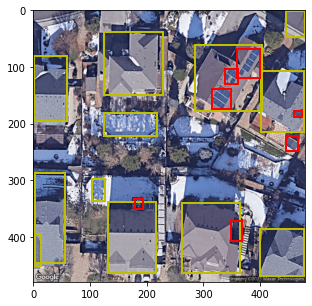

Ratio of area covered by PV to the total image =  0.39425545930862427
predicted #boxes:  19
real #boxes:  10
EXPECTED OUTPUT


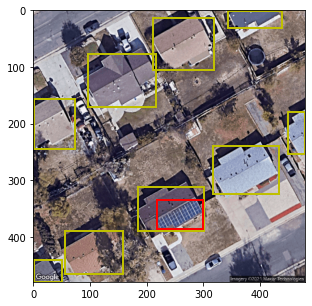

NMS APPLIED MODEL OUTPUT


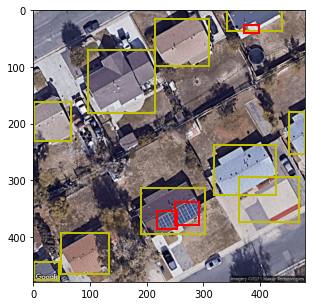

Ratio of area covered by PV to the total image =  0.29975423216819763
predicted #boxes:  27
real #boxes:  8
EXPECTED OUTPUT


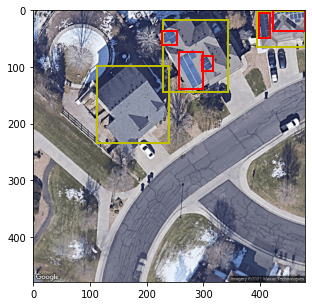

NMS APPLIED MODEL OUTPUT


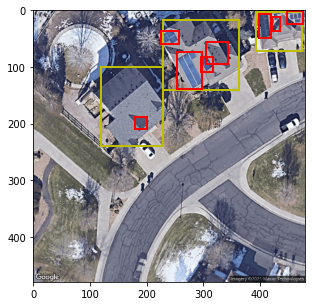

Ratio of area covered by PV to the total image =  0.1962825357913971
predicted #boxes:  22
real #boxes:  9
EXPECTED OUTPUT


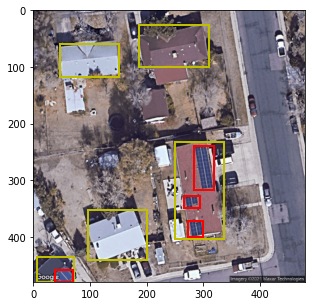

NMS APPLIED MODEL OUTPUT


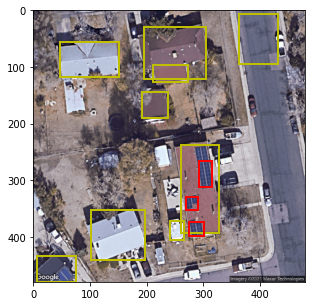

Ratio of area covered by PV to the total image =  0.22200143337249756
predicted #boxes:  34
real #boxes:  7
EXPECTED OUTPUT


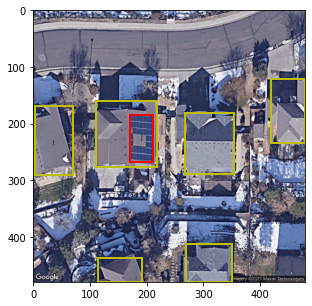

NMS APPLIED MODEL OUTPUT


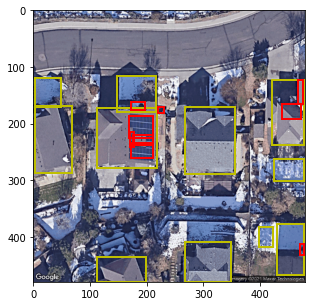

Ratio of area covered by PV to the total image =  0.2802494466304779
predicted #boxes:  19
real #boxes:  9
EXPECTED OUTPUT


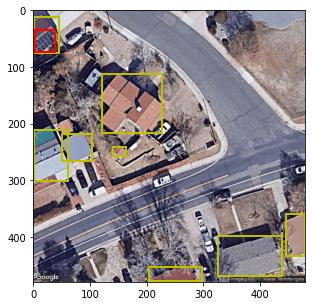

NMS APPLIED MODEL OUTPUT


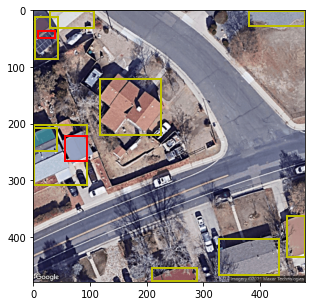

Ratio of area covered by PV to the total image =  0.18775543570518494


In [ ]:
for img, target in dataset_test:
  # img, target = dataset_test[19]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])[0]
      
  print('predicted #boxes: ', len(prediction['labels']))
  print('real #boxes: ', len(target['labels']))
  print('EXPECTED OUTPUT')
  plot_img_bbox(torch_to_pil(img), target)
  # print('MODEL OUTPUT')
  # plot_img_bbox(torch_to_pil(img), prediction)
  nms_prediction, nms_boxes = apply_nms(prediction, iou_thresh=0.2)
  print('NMS APPLIED MODEL OUTPUT')
  plot_img_bbox(torch_to_pil(img), nms_prediction)
  area_solar_by_total_area = sum((nms_boxes[:, 3] - nms_boxes[:, 1]) * (nms_boxes[:, 2] - nms_boxes[:, 0]))/(480*480)
  # print((nms_boxes[:, 3] - nms_boxes[:, 1]) * (nms_boxes[:, 2] - nms_boxes[:, 0]))
  try:
    print("Ratio of area covered by PV to the total image = ", area_solar_by_total_area.item())
  except:
    print("Ratio of area covered by PV to the total image = 0")

In [ ]:
#THIS PART OF CODE ROTATES IMAGES BY 90 DEGREES TO FIND THE PREDICTED BBOX WITH MINIMUM AREA

test_dataset = SolarImagesDataset("/content/gdrive/MyDrive/solar_city_files/testsamples/", 480, 480)
# put the model in evaluation mode
model.eval()
for img in test_dataset:
  area_solar_by_total_area = 1.0
  for i in range(4):
    img = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
    img_tensor = torchtrans.ToTensor()(img)
    with torch.no_grad():
      prediction = model([img_tensor.to(device)])[0]
      
    nms_prediction, nms_boxes = apply_nms(prediction, iou_thresh=0.09)
    temp_area = sum((nms_boxes[:, 3] - nms_boxes[:, 1]) * (nms_boxes[:, 2] - nms_boxes[:, 0]))/(480*480)
    if temp_area<area_solar_by_total_area:
      area_solar_by_total_area = temp_area
      img_final = img
      nms_prediction_final = nms_prediction
  plot_img_bbox(img_final, nms_prediction_final)
  print("Ratio of area covered (minimum out of 90 deg rotations) by PV to the total image = ", area_solar_by_total_area.item())